<a href="https://colab.research.google.com/github/hchen7788/clip_llm_ocr/blob/main/clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## try

data prep

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

mnist_train = MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = MNIST(root='./data', train=False, transform=transform, download=True)

# create data loaders
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 60789869.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108156869.49it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29355499.13it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3852483.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



model prep

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

generate embeddings and classify

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Process images through the processor (resize & normalization)
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        image_features = model.get_image_features(**inputs)

        # Prepare text prompts and encode them
        text_prompts = [f"a photo of a {i}" for i in range(10)]
        text_inputs = processor(text=text_prompts, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_inputs)

        # Calculate similarities and predictions
        similarities = torch.einsum("nd,md->nm", image_features, text_features)
        # similarities = torch.nn.functional.cosine_similarity(image_features, text_features)
        # similarities: a list of probabilities for the 9 classes
        predictions = similarities.argmax(dim=1)
        print("predictions", predictions)
        print("labels", labels)

        correct += (predictions == labels).sum().item()
        print(f"correct: {correct}")
        total += labels.size(0)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


predictions tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')
correct: 10
predictions tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
labels tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
        6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7,
        3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5], device='cuda:0')
correct: 15
pr

evaluate

In [ ]:
accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

## simple clip api



dataset loading

11490434/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


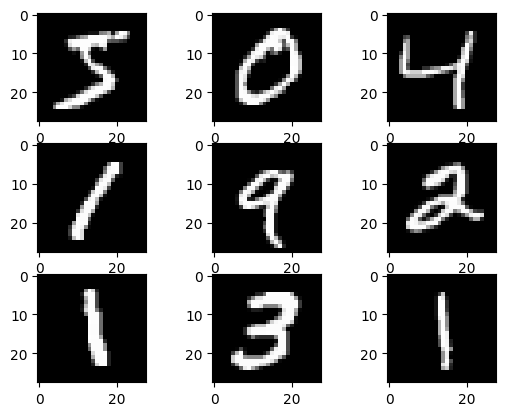

In [ ]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

try with one image

In [ ]:
pip install tqdm

In [ ]:
import numpy as np
import torch

from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

correct, total = 0, 0

# pyplot.imshow(train_X[7], cmap=pyplot.get_cmap('gray'))
# print(train_y[7])

text_prompts = [f"a photo of a {i}" for i in range(10)]

for i in tqdm(range(10000)):
  image_with_channel = np.expand_dims(train_X[i], axis=0)
  image_tensor = torch.tensor(image_with_channel, dtype=torch.float).to(device)
  image_tensor_rgb = image_tensor.repeat(3, 1, 1)

  inputs = processor(text=text_prompts, images=image_tensor_rgb, return_tensors="pt", padding=True)
  inputs = {k: v.to(device) for k, v in inputs.items()}
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image  # image-text similarity score

  similarities = logits_per_image.softmax(dim=1)
  predictions = similarities.argmax(dim=1)
  correct += 1 if predictions == train_y[i] else 0
  total += 1

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 10000/10000 [05:55<00:00, 28.16it/s]

Accuracy: 25.06%


## most recent

In [ ]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yrz81yu0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yrz81yu0
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56

In [ ]:
from transformers import CLIPProcessor, CLIPModel

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
import clip
import os
from torchvision.datasets import  MNIST, CIFAR10
import numpy as np

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

labels = ['0','1','2','3','4','5','6','7','8','9',]
prompt_templates = ['a photo of the number: "{}".',]

@torch.no_grad()
def evaluate(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

@torch.no_grad()
def extract_text_features():
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for label in labels:
        texts = [prompt.format(label) for prompt in prompt_templates]
        print(texts)
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

In [ ]:
import os

dataset = MNIST(root=os.path.expanduser("~/.cache"), download=True, train=False)
model, preprocess = clip.load('RN50', device)

image_features = []
image_labels = []
for image, class_id in dataset:
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image_input)
    image_feature /= image_feature.norm()
    image_features.append(image_feature)
    image_labels.append(class_id)
image_features = torch.stack(image_features, dim=1).to(device)
image_features = image_features.squeeze()

# extract text feature
text_features = extract_text_features()

# compute top-1 accuracy
logits = (100. * image_features @ text_features).softmax(dim=-1)
image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)
top1_acc, top3_acc, top5_acc = evaluate(logits, image_labels, topk=(1, 3, 5))
# print(f'top-1 accuracy for MNIST dataset: {top1_acc[0]:.3f}')
# print(f'top-5 accuracy for MNIST dataset: {top5_acc[0]:.3f}')
print(f'top-1 accuracy for MNIST dataset: {top1_acc:.3f}')
print(f'top-3 accuracy for MNIST dataset: {top3_acc:.3f}')
print(f'top-5 accuracy for MNIST dataset: {top5_acc:.3f}')

['a photo of the number: "0".']
['a photo of the number: "1".']
['a photo of the number: "2".']
['a photo of the number: "3".']
['a photo of the number: "4".']
['a photo of the number: "5".']
['a photo of the number: "6".']
['a photo of the number: "7".']
['a photo of the number: "8".']
['a photo of the number: "9".']
top-1 accuracy for MNIST dataset: 57.450
top-3 accuracy for MNIST dataset: 82.440
top-5 accuracy for MNIST dataset: 91.090


LLM version

In [ ]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 761.0 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-irre37wg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-irre37wg
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 915.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
import clip
import os
from torchvision.datasets import  MNIST, CIFAR10
import numpy as np

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

labels = ['0','1','2','3','4','5','6','7','8','9',]
prompt_templates = ['a photo of the number: "{}".',]

# GPT descriptions
descriptions = {'0': "The number 0 is typically represented as a circle or oval shape. It has a closed loop without any line segments protruding from the shape. The circle is uniform in thickness around its perimeter. There are no internal features within the circle; it is a solid shape.",
                '1': "The number 1 is characterized by a single vertical line. The line is usually straight, extending from the top to the bottom of the visual field. It may have a slight slant or tilt depending on the style of handwriting. The line is typically uniform in thickness from top to bottom.",
                '2': "The number 2 consists of two curved shapes. The top part of the number resembles a backward C or a flattened semicircle. The bottom part extends from the midpoint of the top curve and curves outward to the right, resembling a mirrored S shape.",
                '3': "The number 3 is characterized by a combination of curved and straight lines. It begins with a rounded shape similar to a backward C or a semicircle, but with a slight protrusion to the right. From the midpoint of this shape, a diagonal line extends downward and curves slightly to the right, resembling a mirrored 'L' shape.",
                '4': "The number 4 is defined by a combination of straight and curved lines. It begins with a vertical line that extends downward from the top of the visual field. At the midpoint of this line, a horizontal line extends to the right, forming a right angle with the vertical line.",
                '5': "The number 5 consists of a combination of curved and straight lines. It begins with a vertical line that extends downward from the top of the visual field. At the midpoint of this line, a curved line extends outward to the right, resembling a mirrored S shape.",
                '6': "The number 6 is characterized by a combination of curved and straight lines. It begins with a vertical line that extends downward from the top of the visual field. At the midpoint of this line, a curved line extends outward to the right and then curves back inward, resembling a backward C shape.",
                '7': "The number 7 is defined by a combination of straight and curved lines. It begins with a short horizontal line that extends to the right from the top of the visual field. From the midpoint of this line, a diagonal line extends downward and curves slightly to the right, resembling a mirrored L shape.",
                '8': "The number 8 is typically represented as a pair of symmetrical circles or ovals. The circles are closed loops without any line segments protruding from the shapes. They are uniform in thickness around their perimeters and are typically of the same size. There are no internal features within the circles; they are solid shapes.",
                '9': "The number 9 is characterized by a combination of curved and straight lines. It begins with a short horizontal line that extends to the right from the top of the visual field. From the midpoint of this line, a diagonal line extends downward and curves slightly to the left, resembling a mirrored L shape."}

descriptions_2 = {'0': "Number 0: A closed loop shape with uniform thickness around its perimeter.",
                  '1': "Number 1: A single vertical line with uniform thickness from top to bottom.",
                  '2': "Number 2: Two curved shapes, resembling a backward C and a mirrored S, with smooth and uniform curves.",
                  '3': "Number 3: A rounded shape resembling a backward C with a diagonal line extending downward and curving slightly to the right.",
                  '4': "Number 4: A vertical line extending downward with a horizontal line extending to the right, forming a right angle.",
                  '5': "Number 5: A vertical line with a curved line extending outward to the right, resembling a mirrored S, with smooth curves.",
                  '6': "Number 6: A vertical line with a curved line extending outward to the right and curving back inward, resembling a backward C.",
                  '7': "Number 7: A short horizontal line extending to the right with a diagonal line extending downward and curving slightly to the right.",
                  '8': "Number 8: A pair of symmetrical closed loops or circles with uniform thickness around their perimeters.",
                  '9': "Number 9: A short horizontal line extending to the right with a diagonal line extending downward and curving slightly to the left."}

@torch.no_grad()
def evaluate(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

@torch.no_grad()
def extract_text_features():
    model.to(device)
    model.eval()

    zeroshot_weights = []
    for label in labels:
        texts = [descriptions_2[label]]
        print(texts)
        texts = clip.tokenize(texts).to(device)
        class_embeddings = model.encode_text(texts)
        class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
        class_embedding = class_embeddings.mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights

In [ ]:
import os

dataset = MNIST(root=os.path.expanduser("~/.cache"), download=True, train=False)
model, preprocess = clip.load('RN50', device)

In [ ]:
image_features = []
image_labels = []
for image, class_id in dataset:
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_feature = model.encode_image(image_input)
    image_feature /= image_feature.norm()
    image_features.append(image_feature)
    image_labels.append(class_id)
image_features = torch.stack(image_features, dim=1).to(device)
image_features = image_features.squeeze()

# extract text feature
text_features = extract_text_features()

# compute top-1 accuracy
logits = (100. * image_features @ text_features).softmax(dim=-1)
image_labels = torch.tensor(image_labels).unsqueeze(dim=1).to(device)
top1_acc, top3_acc, top5_acc = evaluate(logits, image_labels, (1, 3, 5))
print(f'top-1 accuracy for MNIST dataset: {top1_acc:.3f}')
print(f'top-3 accuracy for MNIST dataset: {top3_acc:.3f}')
print(f'top-5 accuracy for MNIST dataset: {top5_acc:.3f}')

['Number 0: A closed loop shape with uniform thickness around its perimeter.']
['Number 1: A single vertical line with uniform thickness from top to bottom.']
['Number 2: Two curved shapes, resembling a backward C and a mirrored S, with smooth and uniform curves.']
['Number 3: A rounded shape resembling a backward C with a diagonal line extending downward and curving slightly to the right.']
['Number 4: A vertical line extending downward with a horizontal line extending to the right, forming a right angle.']
['Number 5: A vertical line with a curved line extending outward to the right, resembling a mirrored S, with smooth curves.']
['Number 6: A vertical line with a curved line extending outward to the right and curving back inward, resembling a backward C.']
['Number 7: A short horizontal line extending to the right with a diagonal line extending downward and curving slightly to the right.']
['Number 8: A pair of symmetrical closed loops or circles with uniform thickness around their 

In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

OCR IMPLEMENTATION

In [ ]:
import easyocr
from keras.datasets import mnist
reader = easyocr.Reader(['ch_sim','en']) # this needs to run only once to load the model into memory
# result = reader.readtext('d3.jpg')
# reader.readtext('d3.jpg', detail = 0)
# reader.readtext('img_1.jpg', detail = 0)
reader.readtext('img_10.jpg', detail = 0)
reader.readtext('img_11.jpg', detail = 0)
reader.readtext('img_12.jpg', detail = 0)
# reader.readtext('img_13.jpg', detail = 0)

['7']

SENTENCE BERT TEXT ENCODER

In [ ]:
from transformers import BertConfig, BertModel

# Initializing a BERT google-bert/bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the google-bert/bert-base-uncased style configuration
model = BertModel(configuration)

# Accessing the model configuration
configuration = model.config